In [ ]:
from helper import split_name
from read_data import pull_data, prepare_data, get_expert_projections
from modeling import split_data_random, create_baseline, tune_xgb, create_model, generate_prediction_intervals, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, finalize_predictions, split_batters_if_of, create_draft_pool, calculate_relative_value, determine_optimal_k, segment_players
from config import BAT_POS_OVERRIDES, AGG_YEARS, SCORING_RULES, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, param_space
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

FORMAT = "UD" # <- Indicator for scoring format ("UD" for Underdog, "DK" for DraftKings, etc.)
START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33
SEED = 952612

# Dampening parameter for MLB positional groups, helpful for re-balancing rankings based on positional ADP demands
POS_DAMPENING_MAP = {
    "P": 0.9,    
    "IF": 0.9,   
    "OF": 1.1,   
}

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

C:\Users\jorda\Documents\development\baseball_modeling\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [3]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
    fmt=FORMAT
)

# Prepare data for modeling
batting_df, pitching_df, batting_pred, pitching_pred = prepare_data(
    batting_df,
    pitching_df,
    pred_season=END_YEAR,
)

Loaded existing UD data files.


In [4]:
# TODO: Fix up n_estimators documentation
# TODO: Create a feature_engineering.py file

# Pulling FantasyPros Projection Data

In [5]:
batting_projections, pitching_projections = get_expert_projections(
    batting_url=batting_url,
    pitching_url=pitching_url,
    fmt=FORMAT,
    scoring_rules=SCORING_RULES,
)

# Creating Batting Model

## Creating baseline batting predictions

In [6]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(batting_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

# Compiling baseline predictions
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp.head(10))

[Test] RMSE: 295.080 | MAE: 233.036 | R^2: 0.541 | Spearman: 0.722


,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
289,Juan Soto,1814.0,1643.670044,-170.329956,170.329956,2024,25,1799.0
644,Albert Pujols,1628.0,1635.036499,7.036499,7.036499,2006,26,1806.0
217,David Wright,1587.0,1572.957764,-14.042236,14.042236,2005,22,1555.0
465,Freddie Freeman,1648.0,1557.178955,-90.821045,90.821045,2021,31,1559.0
560,Jimmy Rollins,1858.0,1540.234863,-317.765137,317.765137,2006,27,1678.0
51,Corbin Carroll,1568.0,1539.614380,-28.385620,28.385620,2024,23,1477.0
701,Alex Rodriguez,1648.0,1519.977295,-128.022705,128.022705,2005,29,1923.0
393,Miguel Cabrera,1718.0,1517.938721,-200.061279,200.061279,2010,27,1708.0
630,Hanley Ramirez,1407.0,1515.180420,108.180420,108.180420,2009,25,1622.0
95,Manny Ramirez,1428.0,1507.297729,79.297729,79.297729,2005,33,1682.0


# Building Batting Model

# Batting Predictions

In [7]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:squarederror",
    metric="rmse",     
    evals=75,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
batting_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=batting_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:squarederror",
    metric="rmse",
    n_bootstrap=50,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

100%|██████████| 75/75 [04:37<00:00,  3.71s/trial, best loss: 308.80607465309566]
[Early stopping summary] mean=282, min=103, max=736
Best Parameters: {'learning_rate': 0.023015156114888687, 'max_leaves': 21, 'grow_policy': 'lossguide', 'subsample': 0.755367401879522, 'colsample_bytree': 0.8194791887547979, 'min_child_weight': 6.833242879046229, 'reg_lambda': 9.124450419719267, 'reg_alpha': 0.004216073967139701, 'gamma': 1.6588721056612877e-05}
[Best trial @ val] optimized=rmse | RMSE=308.806 | MAE=244.363 | R^2=0.477 | SPEAR=0.688 


Bootstrapping prediction intervals: 100%|██████████| 50/50 [03:09<00:00,  3.80s/it]


In [8]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:squarederror",
    metric="rmse",
    random_state=SEED,
    id_cols=["IDfg"],        
)

[Test] RMSE: 289.531 | MAE: 230.314 | R^2: 0.558 | SPEAR: 0.730


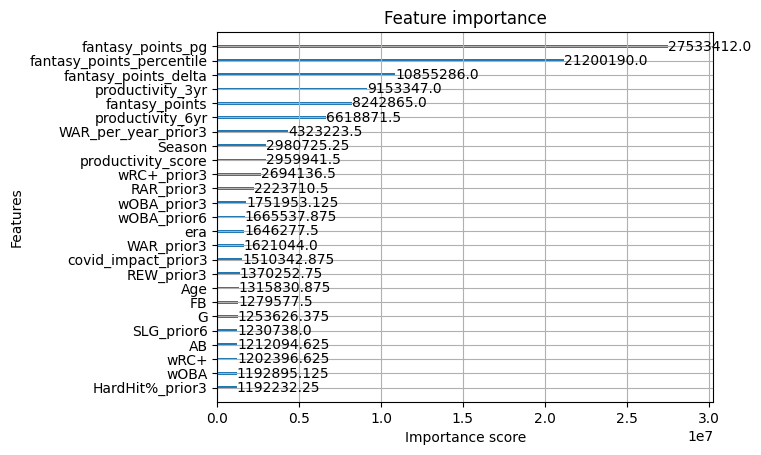

In [9]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [10]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
644,Albert Pujols,1628.0,1685.190674,57.190674,57.190674,2006,26,1806.0
217,David Wright,1587.0,1550.489746,-36.510254,36.510254,2005,22,1555.0
393,Miguel Cabrera,1718.0,1536.666748,-181.333252,181.333252,2010,27,1708.0
701,Alex Rodriguez,1648.0,1519.100464,-128.899536,128.899536,2005,29,1923.0
289,Juan Soto,1814.0,1511.107788,-302.892212,302.892212,2024,25,1799.0
465,Freddie Freeman,1648.0,1503.009644,-144.990356,144.990356,2021,31,1559.0
630,Hanley Ramirez,1407.0,1483.749634,76.749634,76.749634,2009,25,1622.0
56,Shohei Ohtani,1635.0,1483.016235,-151.983765,151.983765,2022,27,1483.0
269,Nolan Arenado,1654.0,1455.999512,-198.000488,198.000488,2016,25,1684.0
95,Manny Ramirez,1428.0,1455.952393,27.952393,27.952393,2005,33,1682.0


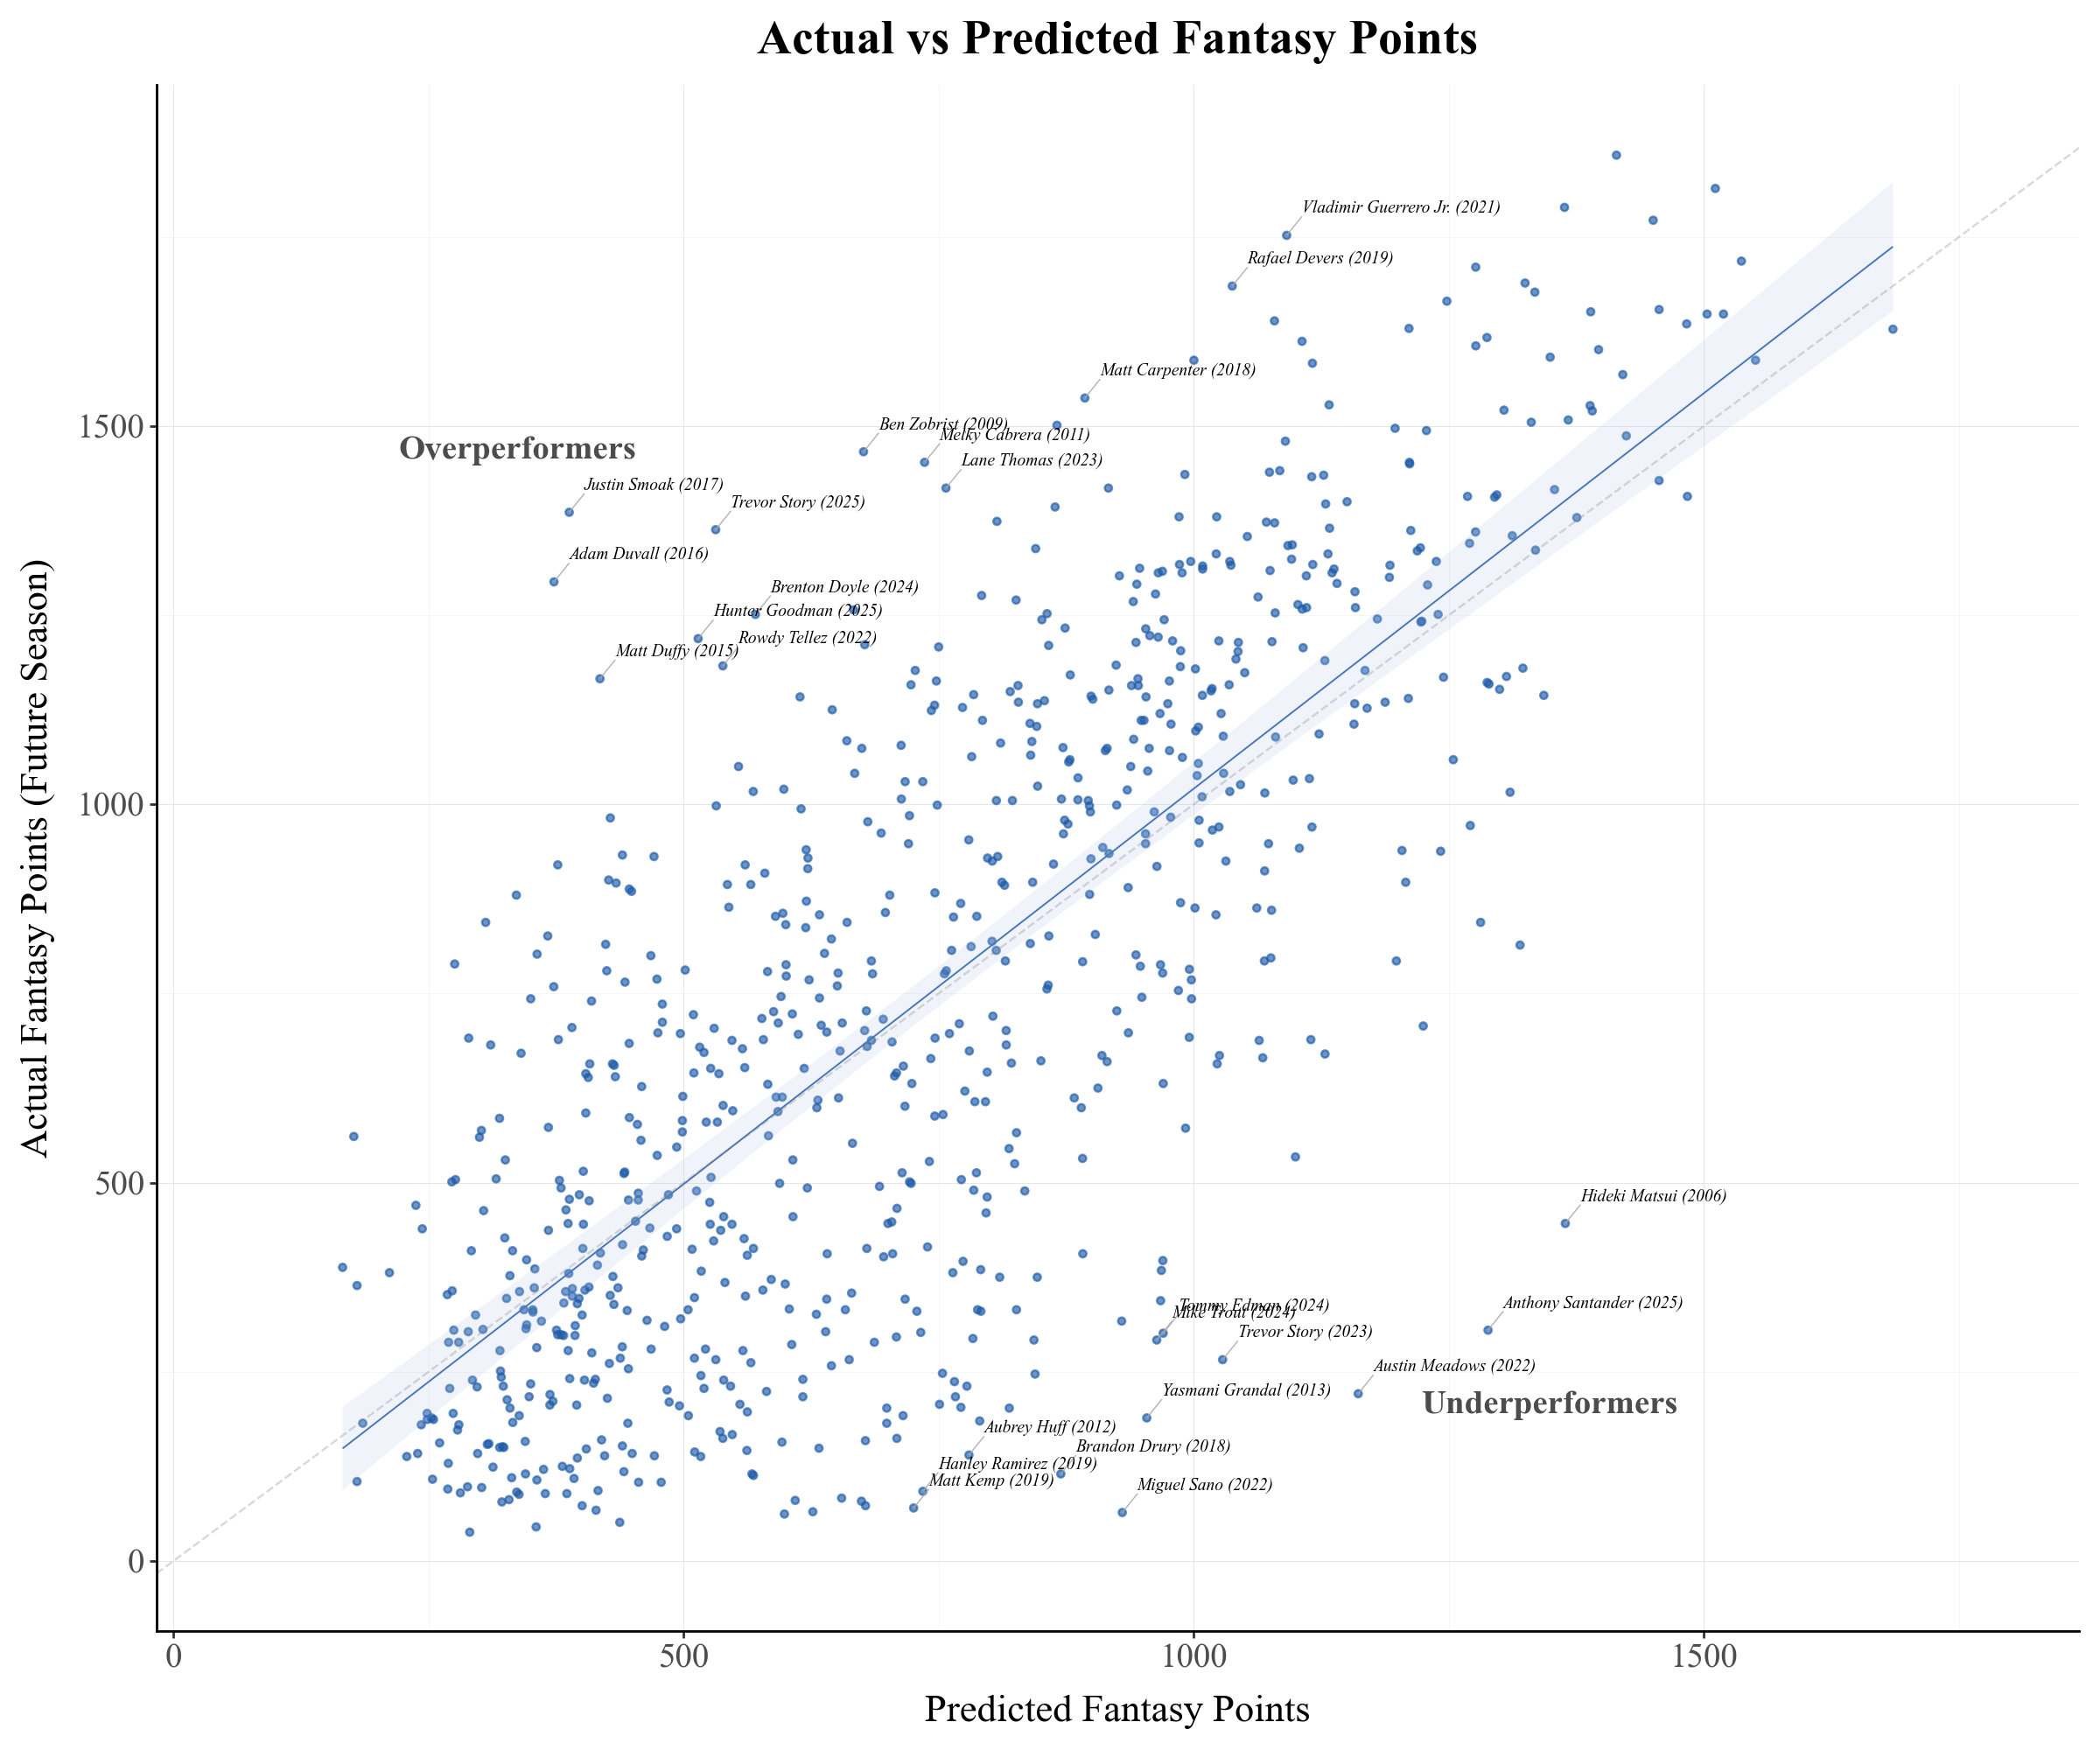

In [11]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

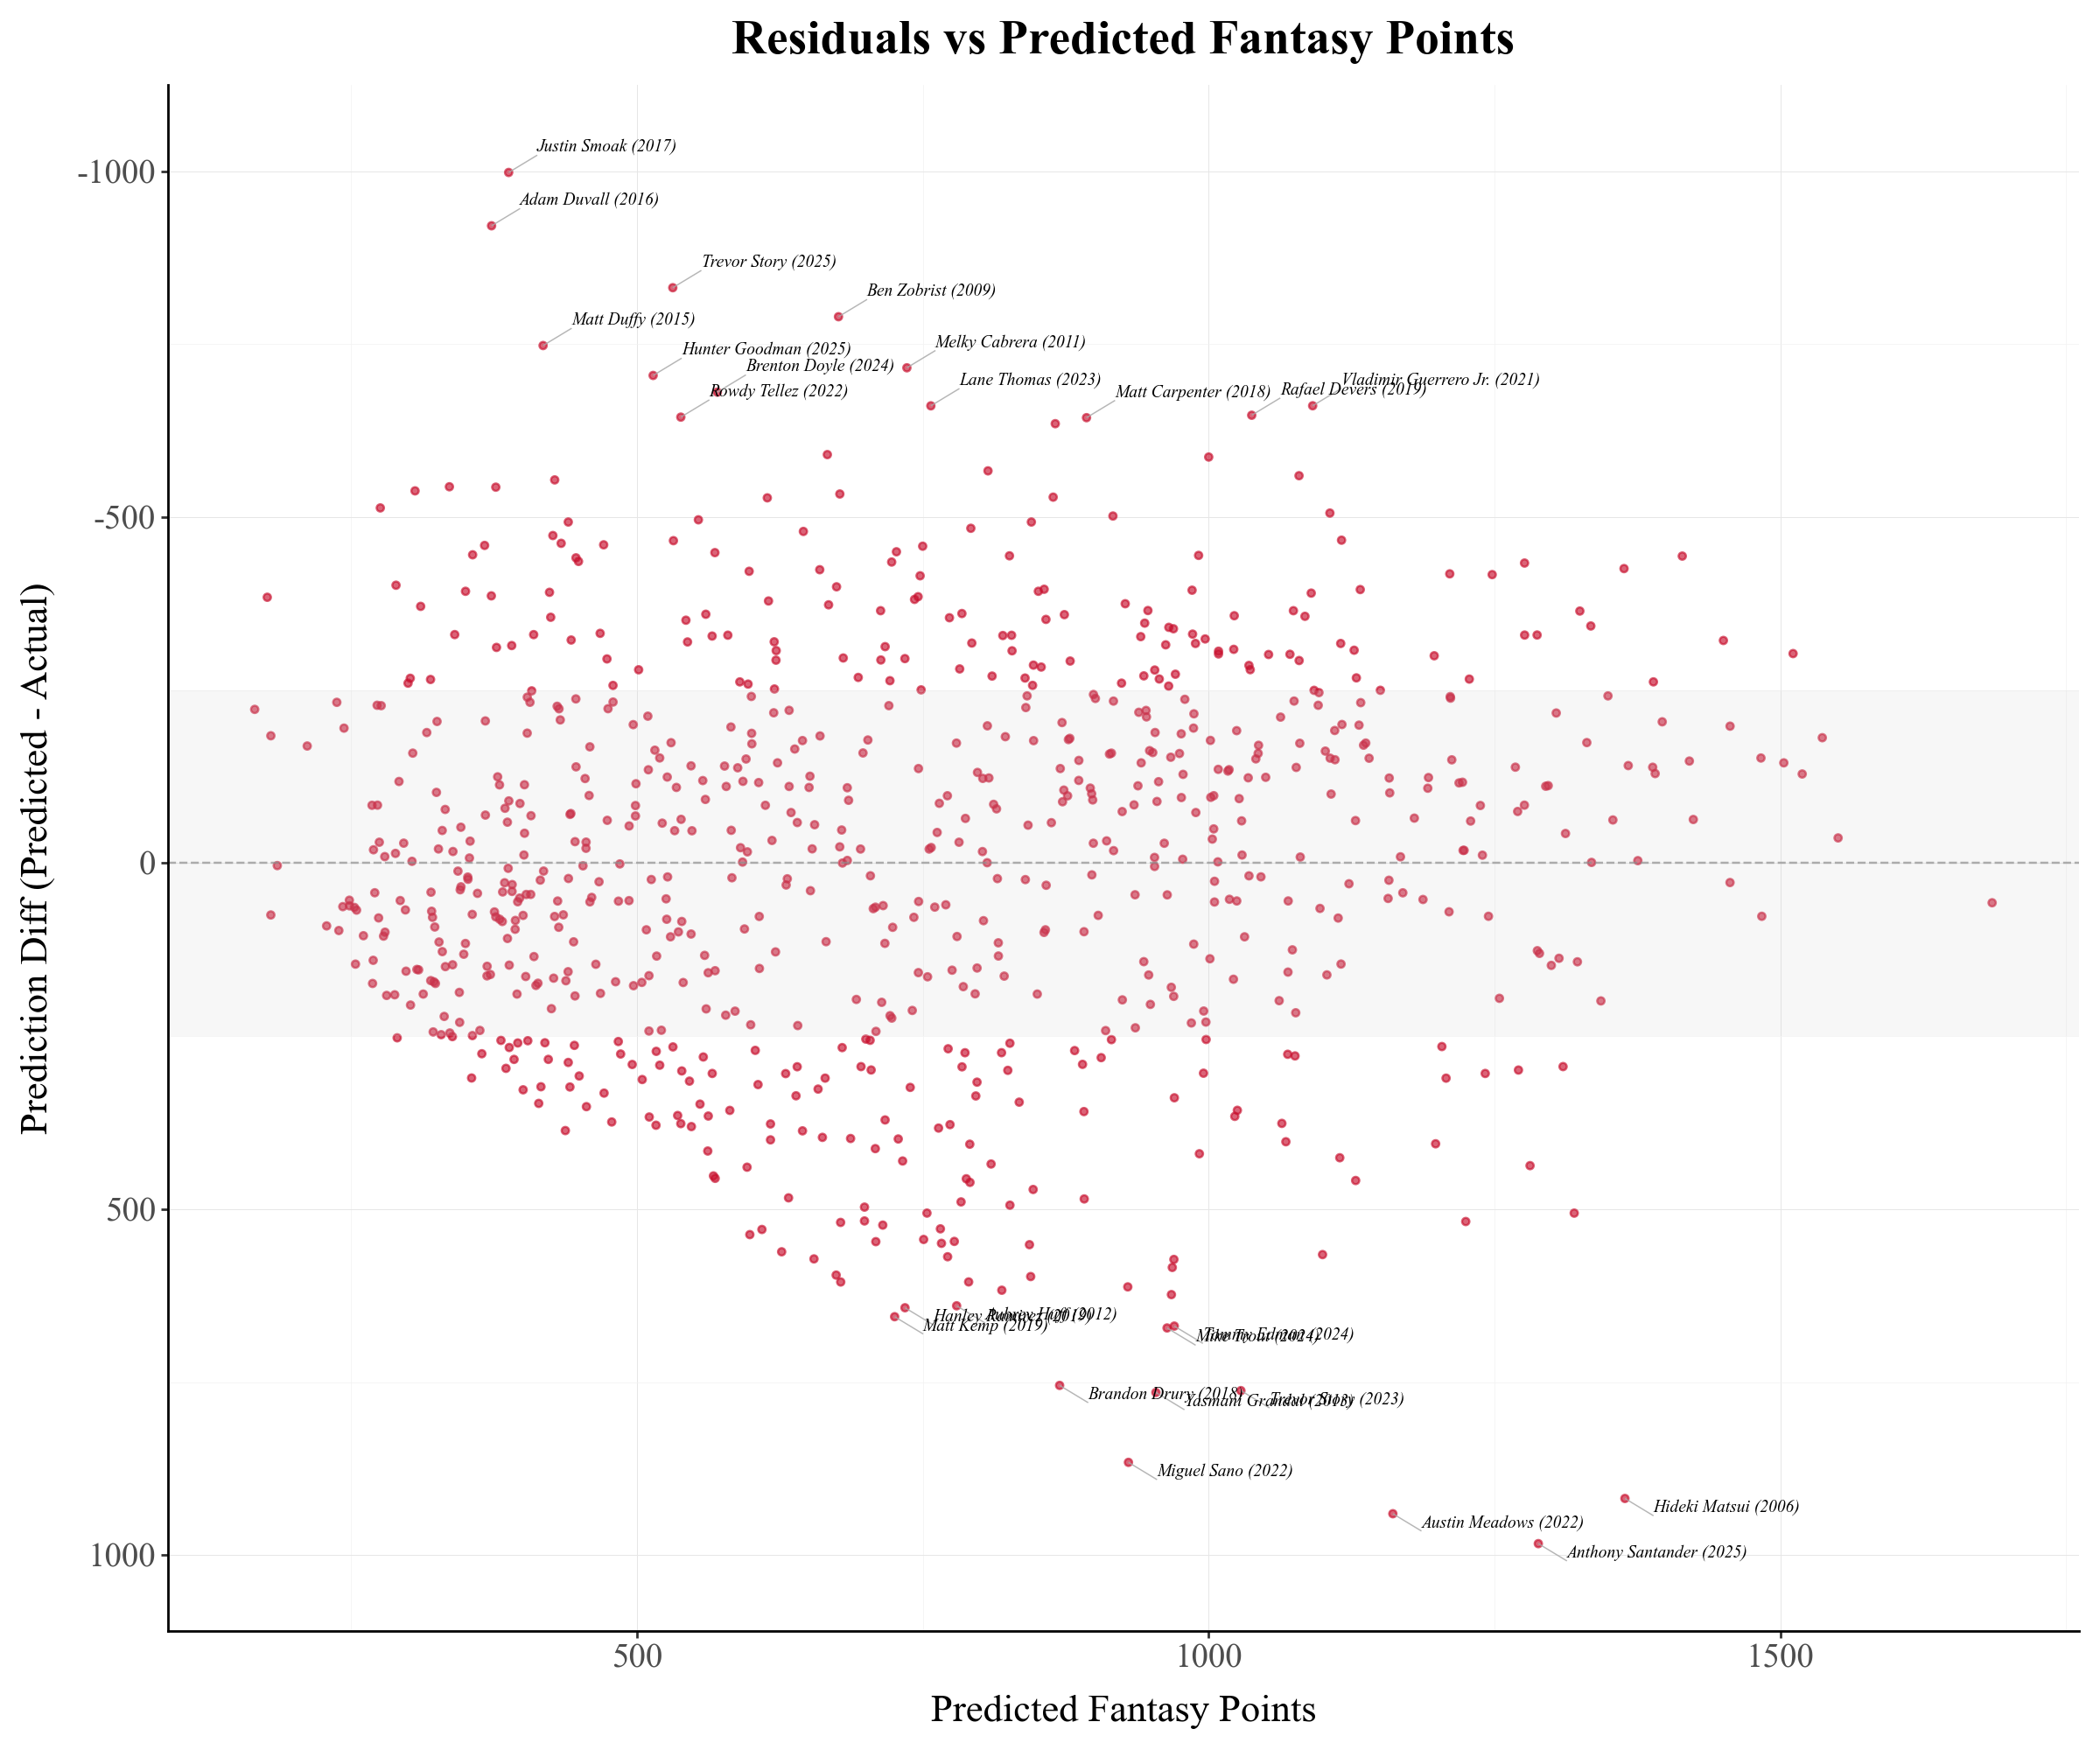

In [12]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=25,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

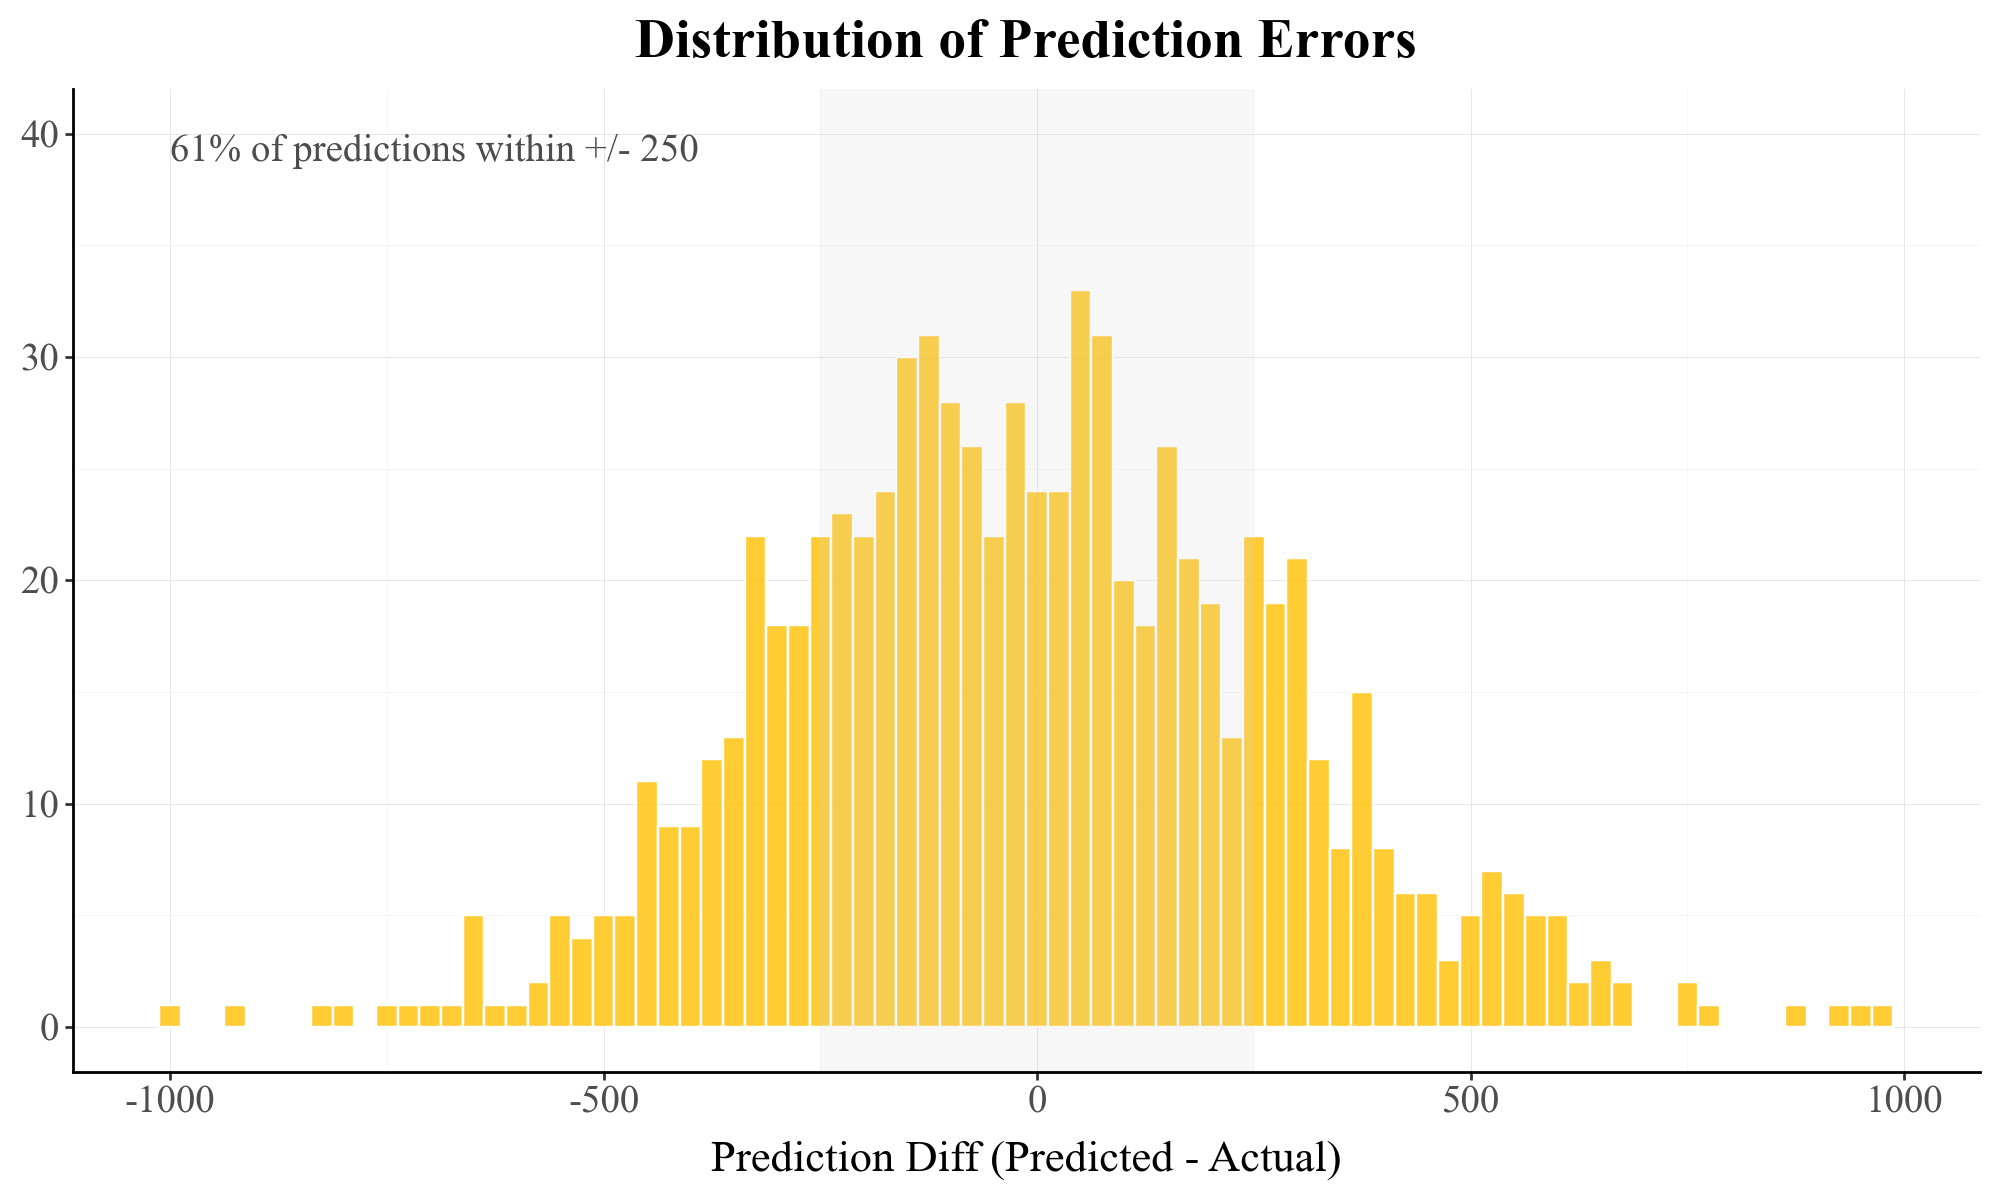

In [ ]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=30,
    x_annotate=-1000,    # custom annotation position
    y_annotate=40,      # custom annotation position
)
p3.show()

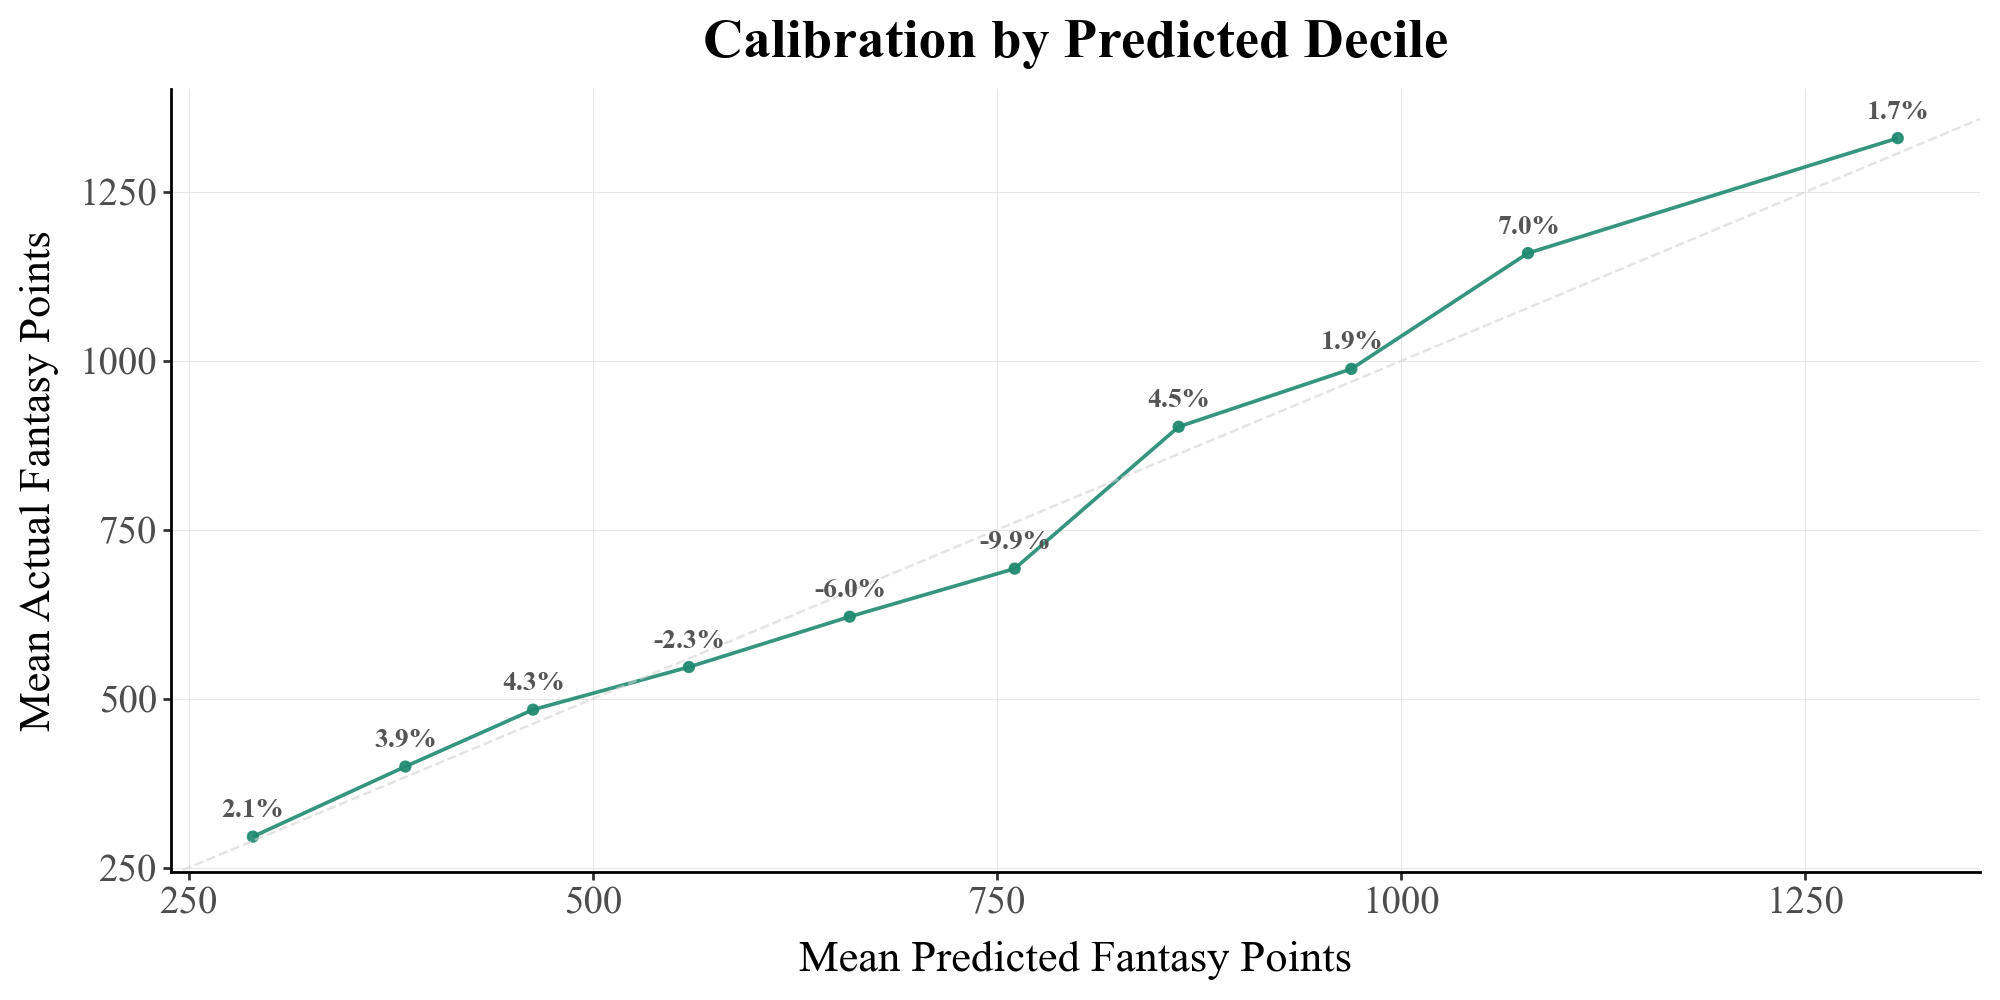

In [14]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [15]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(pitching_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 206.830 | MAE: 154.837 | R^2: 0.486 | Spearman: 0.597


In [16]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
39,David Price,1245.3,1305.857544,60.557544,60.557544,2014,28,1362.3
131,Felix Hernandez,1165.6,1188.022339,22.422339,22.422339,2010,24,1319.6
655,Jacob deGrom,1267.0,1176.240723,-90.759277,90.759277,2018,30,1385.0
692,Roy Halladay,685.3,1113.625977,428.325977,428.325977,2011,34,1271.6
723,Madison Bumgarner,1299.6,1105.703125,-193.896875,193.896875,2015,25,1233.3
677,Dan Haren,1107.0,1079.839844,-27.160156,27.160156,2009,28,1186.3
140,Cole Hamels,1099.0,1062.943970,-36.056030,36.056030,2010,26,1104.6
330,James Shields,1097.6,1053.335083,-44.264917,44.264917,2012,30,1158.6
241,Brandon Webb,1143.3,1044.744751,-98.555249,98.555249,2006,27,1076.0
551,Tim Lincecum,1166.3,1033.095947,-133.204053,133.204053,2009,25,1347.3


# Pitching Predictions

In [17]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:squarederror",
    metric="rmse",     
    evals=75,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
pitching_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=pitching_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:squarederror",
    metric="rmse",
    n_bootstrap=50,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

100%|██████████| 75/75 [04:14<00:00,  3.39s/trial, best loss: 189.79198614761302]
[Early stopping summary] mean=320, min=64, max=756
Best Parameters: {'learning_rate': 0.016176501379945418, 'max_leaves': 10, 'grow_policy': 'lossguide', 'subsample': 0.9146012016744084, 'colsample_bytree': 0.6957990603743132, 'min_child_weight': 8.477611710096678, 'reg_lambda': 9.75012544768727, 'reg_alpha': 4.626210235459818, 'gamma': 0.23191568858535208}
[Best trial @ val] optimized=rmse | RMSE=189.792 | MAE=142.576 | R^2=0.565 | SPEAR=0.661 


Bootstrapping prediction intervals: 100%|██████████| 50/50 [02:43<00:00,  3.27s/it]


In [18]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:squarederror",
    metric="rmse",
    random_state=SEED,
    id_cols=["IDfg"],          
)

[Test] RMSE: 200.749 | MAE: 150.921 | R^2: 0.515 | SPEAR: 0.620


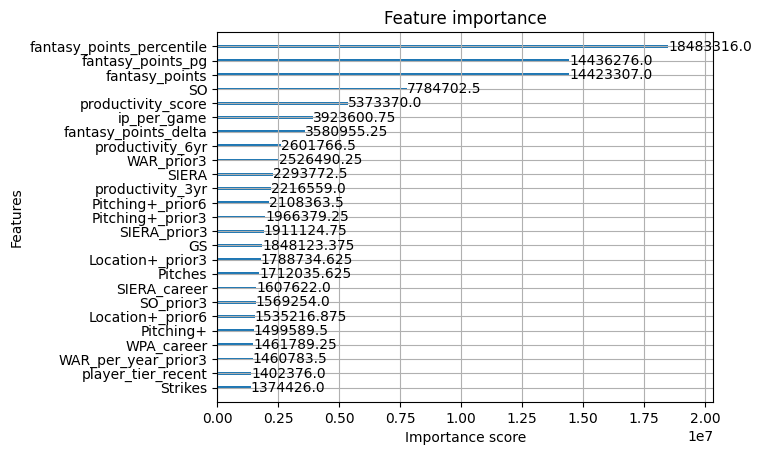

In [19]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [20]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
131,Felix Hernandez,1165.6,1157.604736,-7.995264,7.995264,2010,24,1319.6
39,David Price,1245.3,1137.765015,-107.534985,107.534985,2014,28,1362.3
551,Tim Lincecum,1166.3,1109.668701,-56.631299,56.631299,2009,25,1347.3
692,Roy Halladay,685.3,1047.551270,362.251270,362.251270,2011,34,1271.6
601,Stephen Strasburg,746.0,1035.276733,289.276733,289.276733,2017,28,1065.3
677,Dan Haren,1107.0,1035.135254,-71.864746,71.864746,2009,28,1186.3
330,James Shields,1097.6,1029.856567,-67.743433,67.743433,2012,30,1158.6
655,Jacob deGrom,1267.0,1018.500244,-248.499756,248.499756,2018,30,1385.0
140,Cole Hamels,1099.0,1014.974121,-84.025879,84.025879,2010,26,1104.6
241,Brandon Webb,1143.3,1008.134888,-135.165112,135.165112,2006,27,1076.0


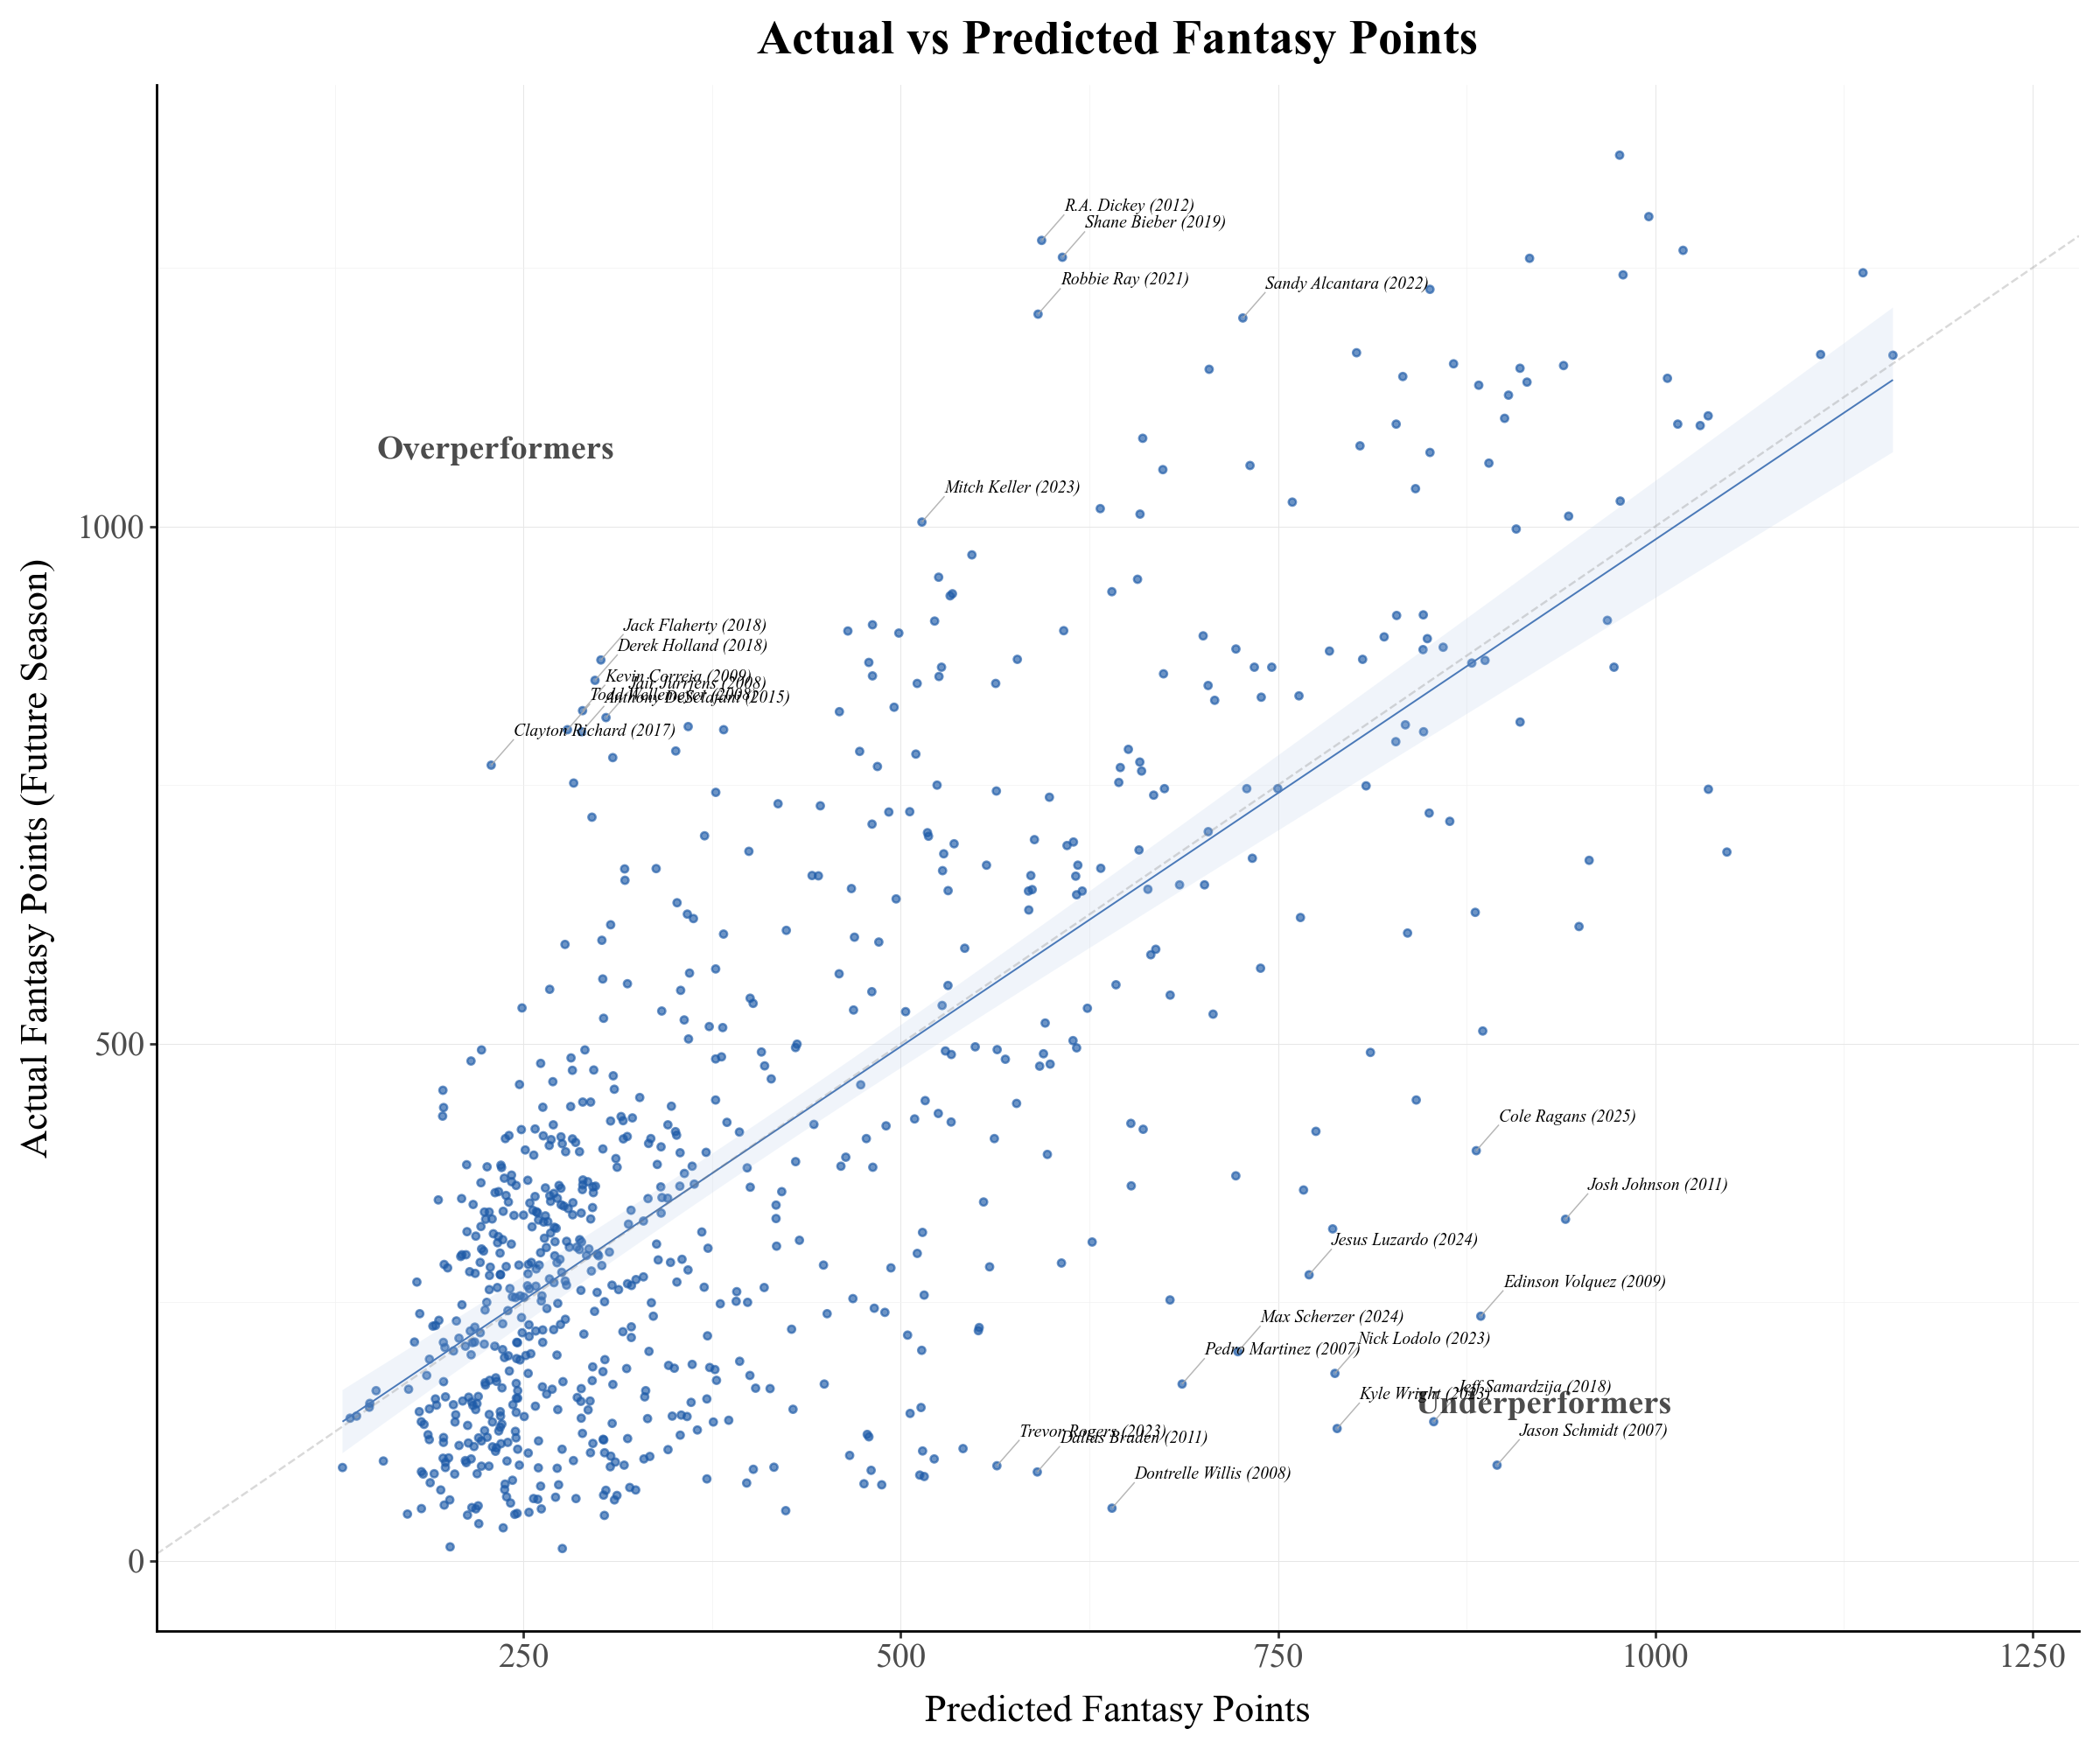

In [21]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

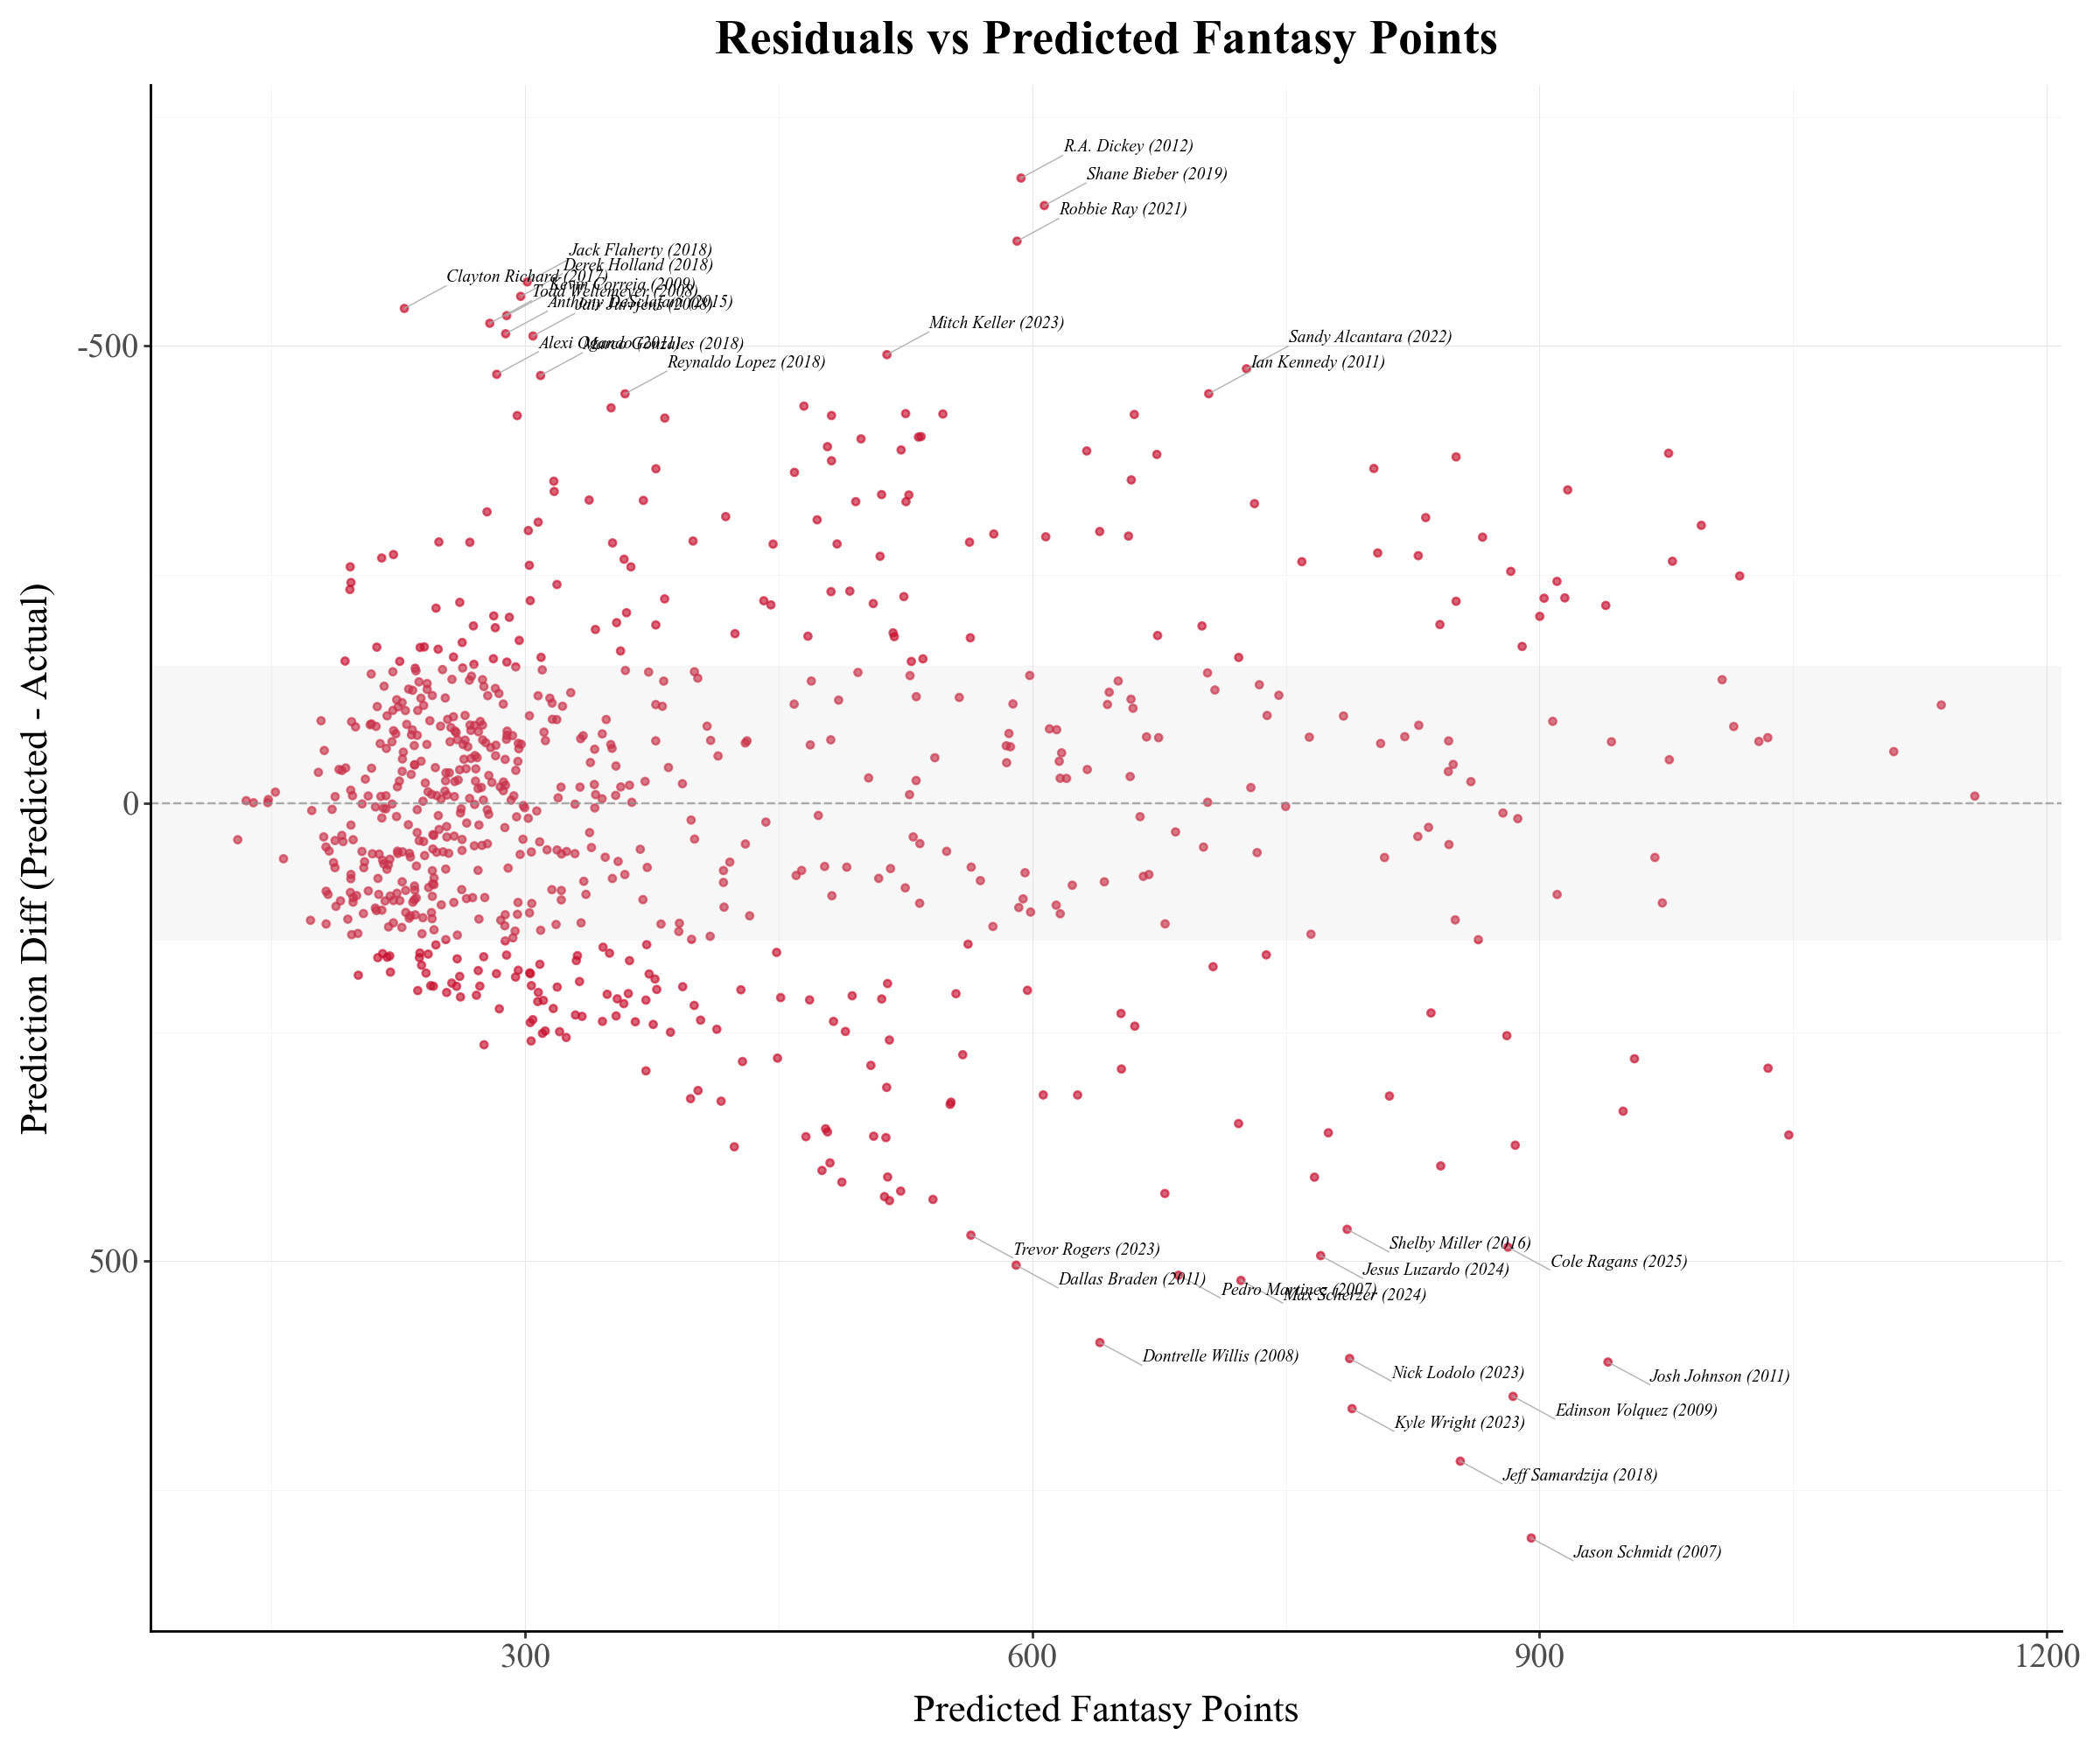

In [22]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=150,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

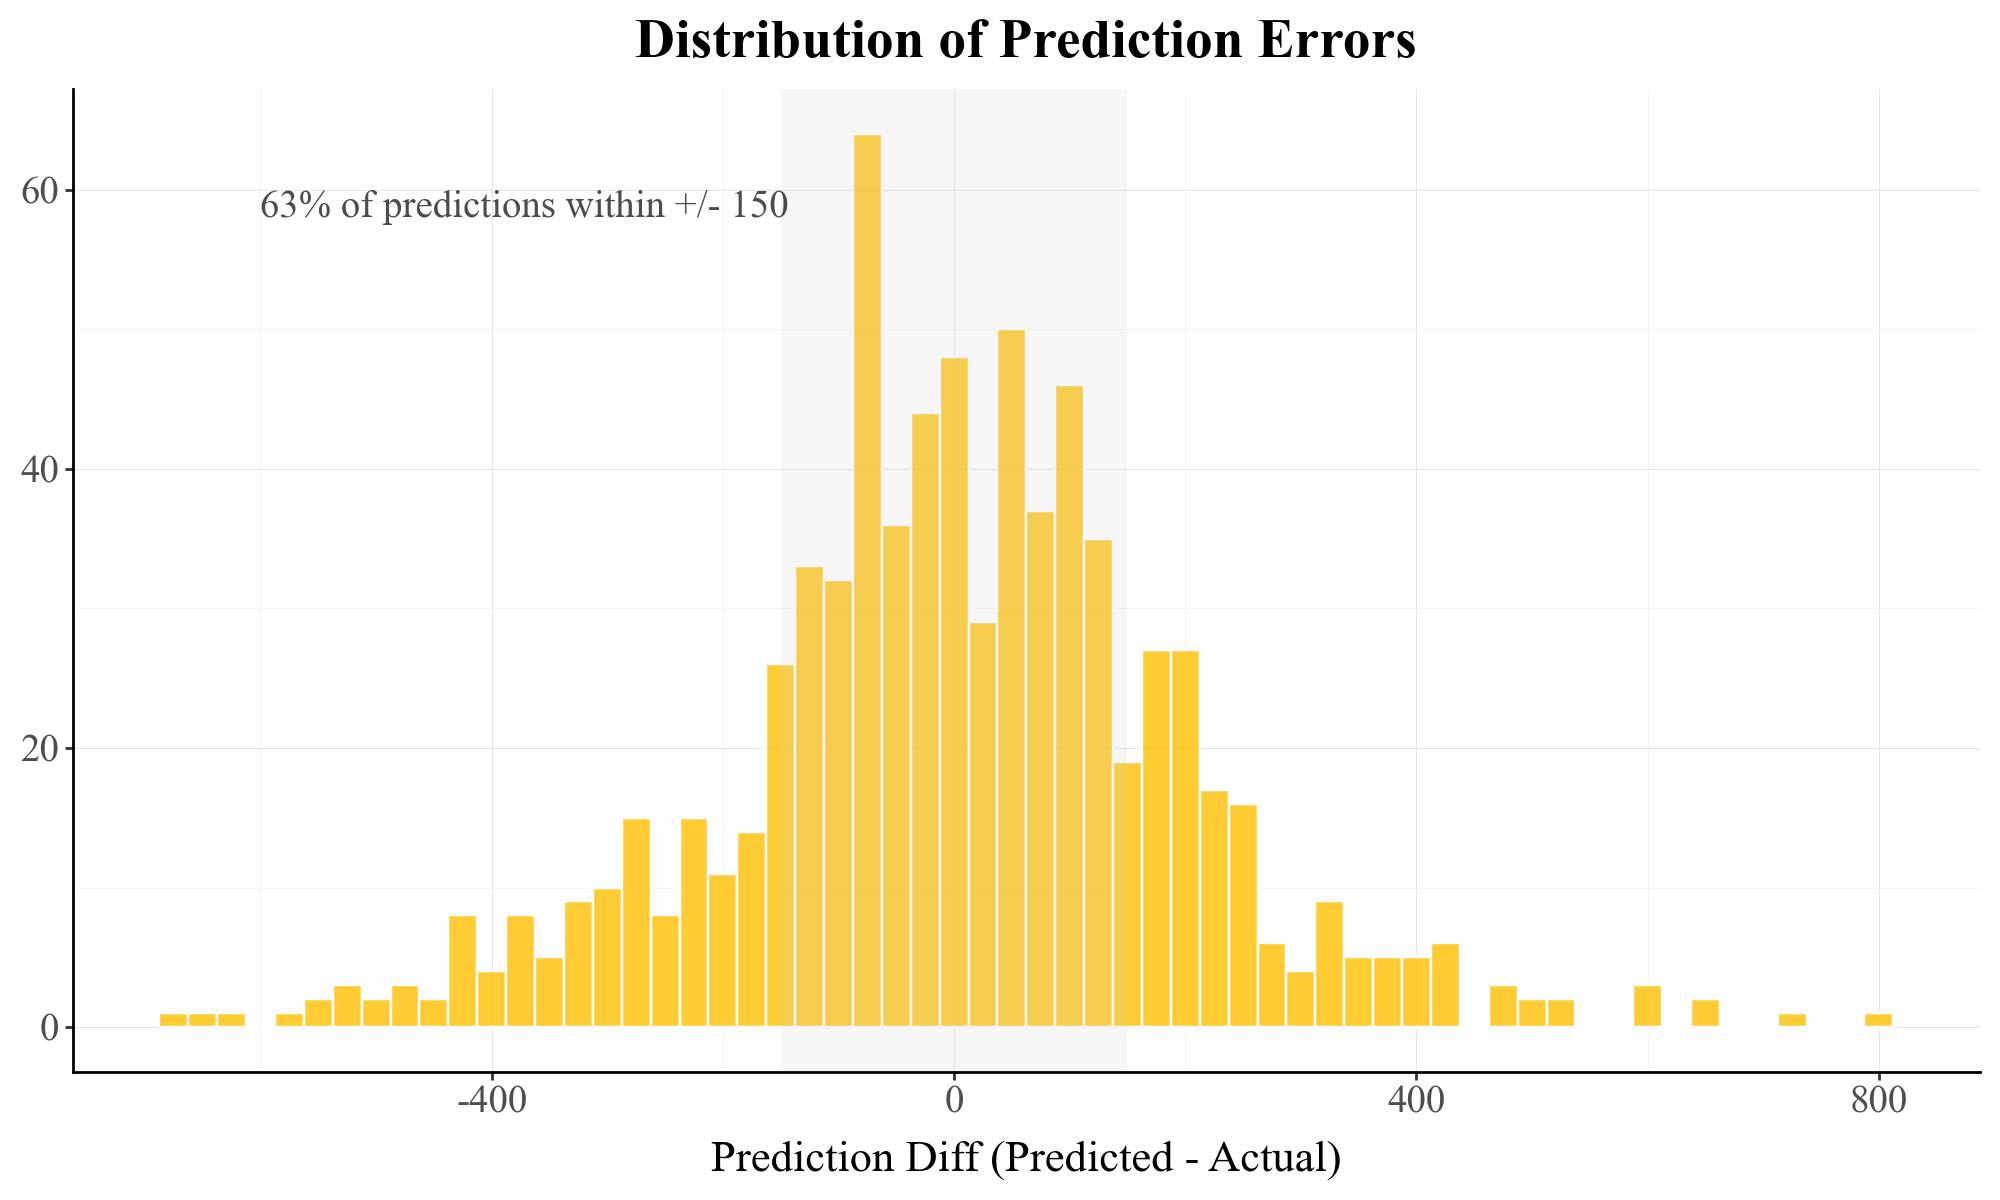

In [23]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=25,
    x_annotate=-600,    # custom annotation position
    y_annotate=60,      # custom annotation position
)
p3.show()

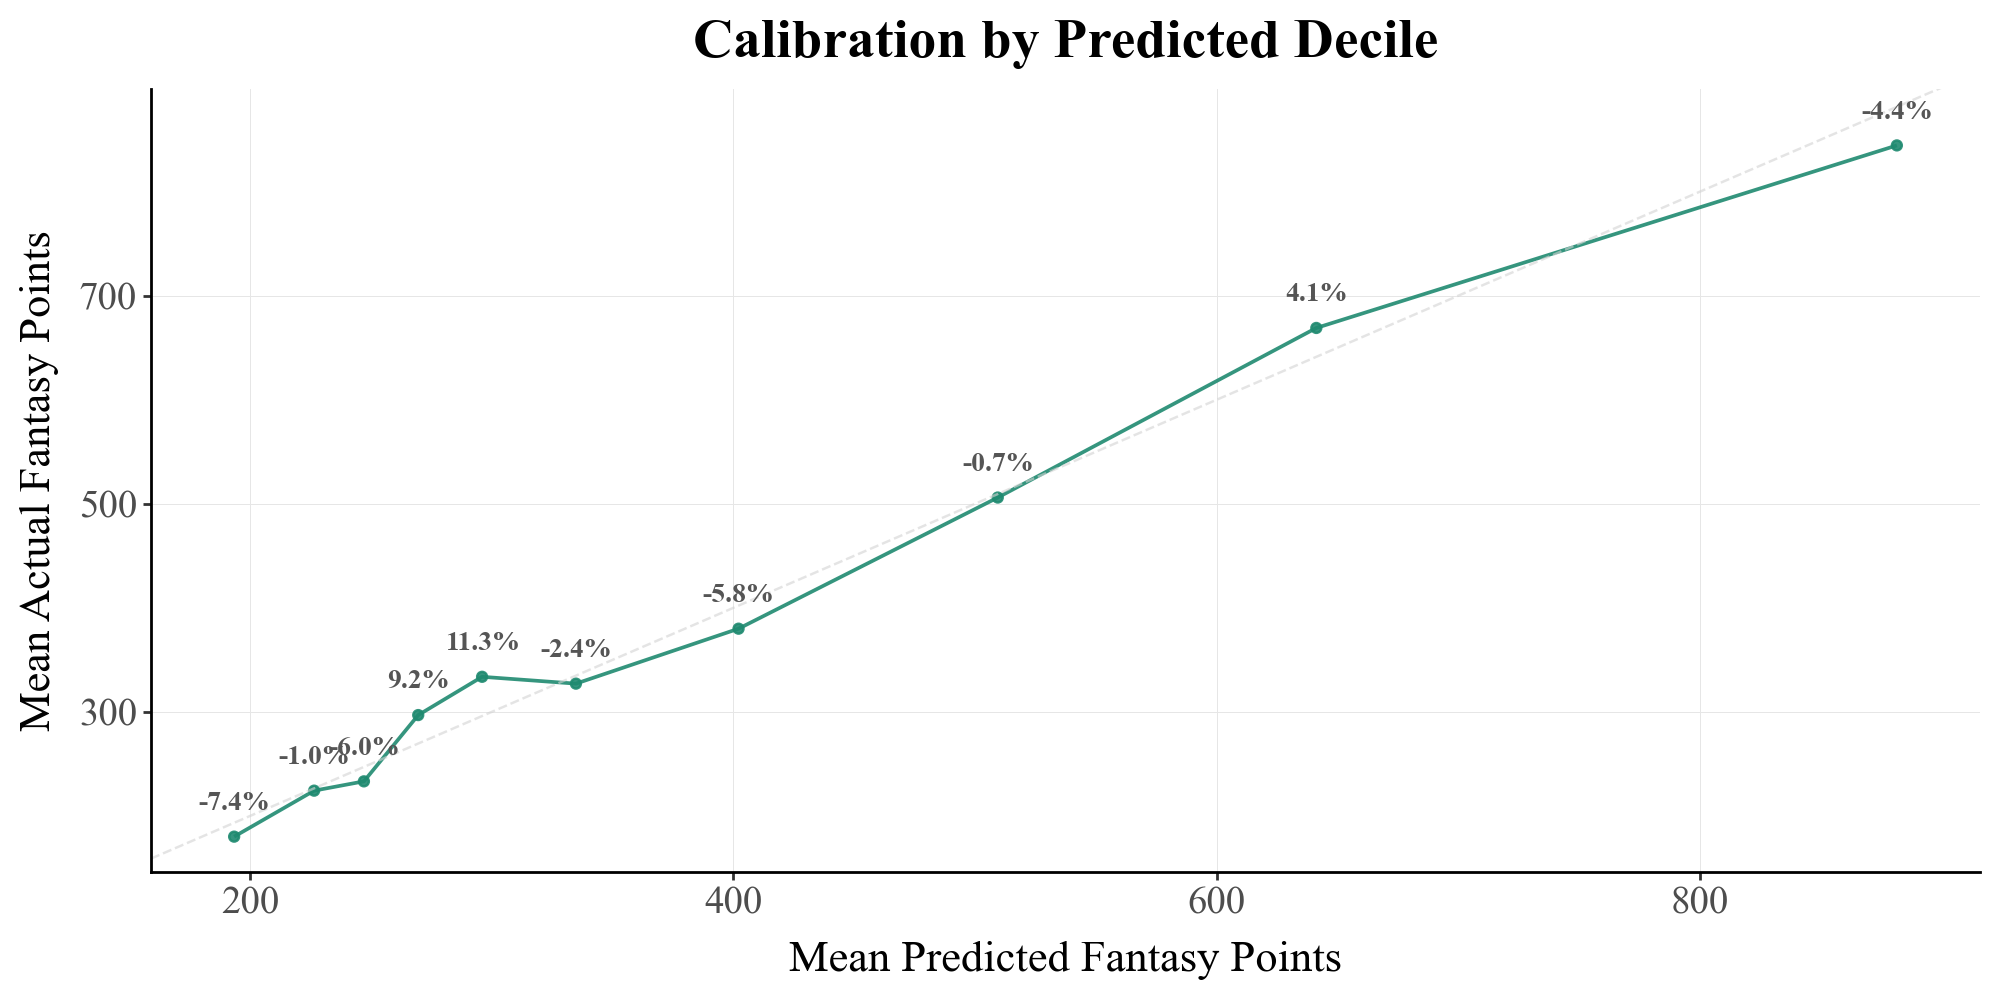

In [24]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [25]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_pred['fantasy_points_pred'] = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_pred['fantasy_points_pred'] = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

# Merge intervals onto pred dataframes
batting_pred = batting_pred.merge(
    batting_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

pitching_pred = pitching_pred.merge(
    pitching_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)

In [26]:
display(batting_pred.head(5))

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,player_tier_recent,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
203,19755,2025,Shohei Ohtani,30,158,611,172,83,25,9,...,star,1655.292114,1479.752627,1068.153723,1479.019883,1870.671609,390.918982,411.598904,0.886048,802.517886
92,15640,2025,Aaron Judge,33,152,541,179,94,30,2,...,star,1619.963623,1472.407181,1068.154848,1476.837625,1869.987926,397.580745,404.252333,0.916717,801.833078
228,20123,2025,Juan Soto,26,160,577,152,88,20,1,...,star,1569.714233,1438.286673,1170.104328,1416.492030,1801.401688,363.115015,268.182345,1.222823,631.297360
59,13510,2025,Jose Ramirez,32,158,593,168,101,34,3,...,star,1535.008545,1386.345262,966.397237,1330.955741,1814.082015,427.736753,419.948025,0.955463,847.684777
373,25878,2025,Corbin Carroll,24,143,564,146,66,32,17,...,star,1469.417847,1503.780469,1042.036526,1461.763299,1968.751180,464.970711,461.743943,0.945409,926.714654


In [27]:
display(pitching_pred.head(5))

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,is_reliever,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
186,17995,2025,Logan Webb,28,34,34,3282,2165,15,5.5,...,0,969.128906,872.472453,648.212523,858.444407,1096.913607,224.441154,224.259929,0.928558,448.701084
24,10310,2025,Zack Wheeler,35,24,24,2394,1549,10,4.0,...,0,916.208069,815.919657,580.747982,756.232553,1190.333004,374.413347,235.171675,1.488780,609.585022
335,22267,2025,Tarik Skubal,28,31,31,2849,2003,13,6.6,...,0,900.317383,845.462551,641.107792,810.642406,1122.480750,277.018200,204.354759,1.251980,481.372958
411,25880,2025,Hunter Brown,26,31,31,2964,1832,12,4.6,...,0,892.276855,920.826631,718.376857,896.862491,1155.096872,234.270241,202.449774,1.060688,436.720015
248,19959,2025,Jesus Luzardo,27,32,32,3015,1955,15,5.3,...,0,882.184143,768.522762,588.359152,747.836412,947.165090,178.642328,180.163610,0.913612,358.805938


In [28]:
# Splitting names into first and last
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
521,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1131.304176,344.383675,353.279006,0.933245,697.662681,max,muncy,LAD,3B,907.0
522,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1131.304176,344.383675,353.279006,0.933245,697.662681,max,muncy,ATH,"2B,3B,SS",594.0
523,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,856.950753,396.901455,376.640898,1.028663,773.542353,max,muncy,LAD,3B,907.0
524,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,856.950753,396.901455,376.640898,1.028663,773.542353,max,muncy,ATH,"2B,3B,SS",594.0


In [29]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

In [30]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
608,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,348.58503,198.51365,209.649462,0.933519,408.163112,luis,garcia,NYM,RP,264.0
609,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,348.58503,198.51365,209.649462,0.933519,408.163112,luis,garcia,NaN,SP,181.6


In [31]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

# Finalizing Predictions & Creating Relative Positional Value Scores

In [32]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

# Assigning position groups, cleaning player names, combining projections, and selecting final columns
batting_final = finalize_predictions(
    batting_final,
    mode="bat",
    position_overrides=BAT_POS_OVERRIDES,
)
pitching_final = finalize_predictions(
    pitching_final,
    mode="pit",
)

# Splitting the batters into infielders and outfielders
batting_final_if, batting_final_of = split_batters_if_of(batting_final)

# Creating final projected score, with a blended weight combining model and expert projections
# Creating initial player rankings based on final projection
# Filtering to player pool based on position
batting_final_if = (
    batting_final_if
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_if,
    )
)

batting_final_of = (
    batting_final_of
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_of,
    )
)

pitching_final = (
    pitching_final
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=pitcher_pool,
    )
)

batting_final = pd.concat([batting_final_if, batting_final_of])

# Assigning player position groups
batting_final = assign_position_group(batting_final, position_col = 'Position')
pitching_final = assign_position_group(pitching_final, position_col = 'Position')

# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

# Setting missing values in the implied_upside column to 1
combined_df['implied_upside'] = combined_df['implied_upside'].fillna(1)

In [33]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

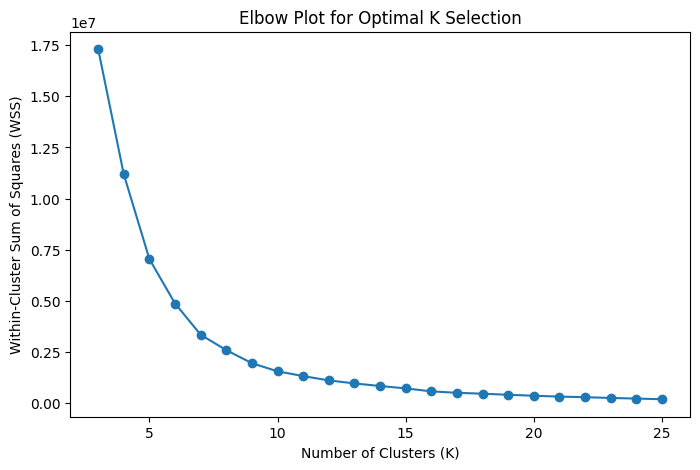

In [34]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [35]:
# Setting a K value and placing players into relative value tiers
final_df = segment_players(value_df, k = 20)

In [36]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'pred_downside', 'pred_upside', 'implied_upside', 'relative_value',  
                     'overall_ranking', 'position_rank', 'player_value_tier']]

In [37]:
# Saving out final dataframe
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}_{FORMAT}.csv', index=False)